# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
# from thick_ptycho.sample_space.sample_space import SampleSpace
# from thick_ptycho.forward_model.solver import ForwardModel
from thick_ptycho.simulation.config import SimulationConfig, BoundaryType, ProbeType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, PWEFullPinTSolver, MSForwardModelSolver, PWEFullPinTSolverPETSc
from matplotlib import pyplot as plt
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

2025-11-05 17:22:33,359 - INFO - === Scan Summary (Continuous) ===
2025-11-05 17:22:33,361 - INFO -   Sample space (x-range): 1.000e-04 m
2025-11-05 17:22:33,362 - INFO -   Sample space (z-range): 7.500e-05 m
2025-11-05 17:22:33,363 - INFO -   Probe diameter:         2.000e-06 m
2025-11-05 17:22:33,366 - INFO -   Number of scan points:  1
2025-11-05 17:22:33,367 - INFO -   Steps in z:             236
2025-11-05 17:22:33,368 - INFO -   Detector Pixels:        150


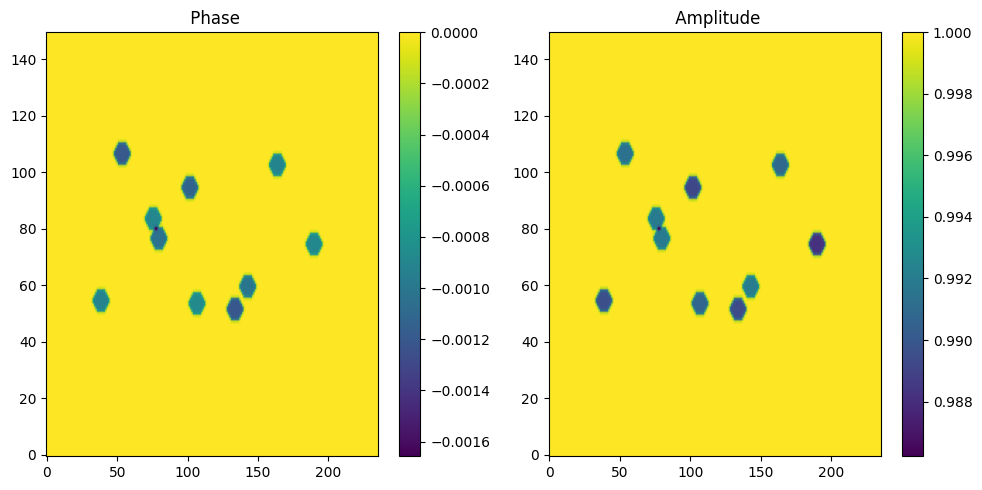

In [2]:
wavelength = 0.635e-6        # meters (0.635 μm)
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]

# --- Refractive index parameters ---
n_medium = 1.0               # background refractive index

# --- Probe configuration ---
probe_dimensions_discrete = [100]
probe_diameter_scale = 0.02
probe_focus = -5e-6                    # focal length [m]
scan_points = 1
step_size = 3                        # pixels between scans

pad_factor = 1.5  # Portion of extra space to add
# Define margin portion (half of extra space)
pad_margin = (pad_factor - 1) / 2.0

# --- Simulation spatial dimensions (in meters) ---
xlims = [0.0, 100e-6]   # meters (sample width)
zlims = [0.0, 75e-6]   # meters (sample thickness)
continuous_dimensions = (xlims, zlims)

# --- Discretization parameters ---
z_range = zlims[1] - zlims[0]
dz = wavelength / 2 
nz = int(z_range / dz)

# TODO: Make this padding apply to all dimensions
probe_width = probe_dimensions_discrete[0]
min_nx = (scan_points - 1) * step_size + probe_width
discrete_dimensions = (int(min_nx * pad_factor), nz)


# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE
probe_type = ProbeType.AIRY_DISK

# --- Create the SimulationConfig object ---
config = SimulationConfig(
    continuous_dimensions=continuous_dimensions,
    discrete_dimensions=discrete_dimensions,
    probe_dimensions=probe_dimensions_discrete,
    scan_points=scan_points,
    step_size=step_size,
    bc_type=bc_type,
    probe_type=probe_type,
    wave_number=k0,
    probe_diameter_scale=probe_diameter_scale,
    #probe_angles=(np.linspace(-15,15,3)),
    probe_focus=probe_focus,
    tomographic_projection_90_degree=True,
    thin_sample=False,
    n_medium=n_medium,
    results_dir="./results",
    use_logging=True
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(config)
simulation_space.summarize()

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)


# # TODO: Make objects move to the centre with padding or define them in min_nx
# # Add 6 spheres of varying positions
# # Base refractive index offsets
delta = 0.01
beta = 0.001

# Variation strength (fractional)
delta_var = 0.20   # ±20% variation in phase shift
beta_var  = 0.20   # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length = 0.05
common_depth = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):

    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand  = beta  * (1 + beta_var  * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        'circle',
        refractive_index_perturbation,
        side_length=common_side_length,
        centre=(cx, cz),
        depth=common_depth,
        gaussian_blur=gaussian_blur
    )
ptycho_object.build_field()
# delta = 0.01
# beta = 0.001
# ptycho_object.load_image("/home/dnz75396/thick_ptycho/notebooks/UKRI.tiff", 
#                          real_perturbation=delta, imaginary_perturbation=beta)
simulation_space.viewer.plot_two_panels(ptycho_object.n_true, view="phase_amp")


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)


### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [3]:
# # Solve Full Space Space, Iterative

# # --- Create Forward Model ---
# time_start = time.time()
# forward_model_pwe = PWEIterativeLUSolver(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes)

# # Iterative solution
# u_pwe = forward_model_pwe.solve()
# time_end = time.time()
# print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
# exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
# intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
#                                                            poisson_noise=True)
# intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
#                                                            poisson_noise=False)

In [4]:
# # Select Centre Probe
# centre_probe_pwe = u_pwe[0,0,simulation_space.num_probes//2, ...]
# simulation_space.viewer.plot_two_panels(centre_probe_pwe,
#                                         view="phase_amp", 
#                                         title="Wavefield Solution PWE",
#                                         xlabel="z (m)",
#                                         ylabel="x (m)")

# plt.plot(simulation_space.x, centre_probe_pwe[:, nz//2])
# plt.show()

# plt.figure(figsize=(8,4))
# p=0
# plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,0]), label=f'probe {p}')
# plt.title("Probe amplitudes (subset)")
# plt.xlabel("x"); plt.legend(); 
# plt.tight_layout(); plt.show()


# plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,-1]), label=f'probe {p}')
# plt.title("Exitwave amplitudes (subset)")
# plt.xlabel("x"); plt.legend(); 
# plt.tight_layout(); plt.show()


In [ ]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_full = PWEFullPinTSolver(simulation_space,
                                ptycho_object,
                                ptycho_probes,
                                alpha=1e-6,
                                atol=1e-5)

# Iterative solution
u_pwe_full = forward_model_pwe_full.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
                                                           poisson_noise=True)
intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(exit_waves=exit_waves_pwe_full, 
                                                           poisson_noise=False)

Setting up PETSc operator and PiT preconditioner...
Preparing PiT components for mode 'forward'...
Constructing PiT operator components...
Setting up PETSc MatShell for A...
Binding PETSc MatShell context...
MatShell ready.
Setting up PETSc PCShell for PiT preconditioner...


Setup time: 0.12s


/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/full_pit_petsc.py:101: SparseEfficiencyWarning: splu converted its input to CSC format
  self._lus = [splu((self.A_bar - (z * self.B_bar)).astype(self.dtype)) for z in self.omegas]


TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

In [ ]:
# Select Centre Probe
centre_probe_pwe = u_pwe_full[0,0,simulation_space.num_probes//2, ...]
simulation_space.viewer.plot_two_panels(centre_probe_pwe,
                                        view="phase_amp", 
                                        title="Wavefield Solution PWE",
                                        xlabel="z (m)",
                                        ylabel="x (m)")

plt.plot(simulation_space.x, centre_probe_pwe[:, nz//2])
plt.show()

plt.figure(figsize=(8,4))
p=0
plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()


plt.plot(simulation_space.x, np.abs(u_pwe[0,0,p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x"); plt.legend(); 
plt.tight_layout(); plt.show()


NameError: name 'u_pwe_full' is not defined